# A Network-based Multimodal Infrastructure for Accelerating Medicine Partnership in Parkinson’s Disease Data Repurposing
---

**[Feixiong Cheng, Ph.D. (Communicating PI)](https://www.lerner.ccf.org/gmi/cheng/)**  
Assistant Professor of Molecular Medicine  
Cleveland Clinic Lerner College of Medicine of Case Western Reserve University  
Email: <a href="mailto:chengf@ccf.org">chengf@ccf.org</a>

**[Ignacio Mata, Ph.D. (MPI)](https://www.lerner.ccf.org/gmi/mata/)**  
Assistant Professor of Molecular Medicine  
Cleveland Clinic Lerner College of Medicine of Case Western Reserve University  
Email: <a href="mailto:matai@ccf.org">matai@ccf.org</a>

### Table of Contents
1. [Introduction](#a1)
2. [Code Base](#a2)
    1. [Framework - Genome/Transcriptome Data Reticulotyping](#a2_1)
    2. [Framework - Deep Learning-based Graph Embedding](#a2_2)
        1. [Random Surfing with Restart](#a2_2_1)
        2. [Positive Pointwise Mutual Information](#a2_2_2)
        3. [Stacked Denoising Autoencoder](#a2_2_3)
    3. [Framework - Network Proximity](#a2_3)
        1. [Human Protein Interactome](#a2_3_1)
        2. [Disease Gene Network Modularity](#a2_3_2)
        3. [Network Proximity](#a2_3_3)
        4. [Random Sampling and Z-Score](#a2_3_4)
        5. [Network Proximity-based Drug Screening](#a2_3_5)
3. [Example Workflow](#a3)
    1. [Example - Genome/Transcriptome Data Reticulotyping](#a3_1)
    3. [Example - Network Proximity](#a3_3)

## Introduction

Parkinson's disease (PD) is a complex neurological disorder with multiple pathophysiological processes, including a-synuclein aggregation, neuro-inflammation, mitochondrial dysfunction, neuronal vulnerability, and neural network alterations. It is estimated that more than 1 million people with PD live in the United States and approximately 60,000 Americans are diagnosed each year. There are no treatments that slow the neurodegenerative process for PD; furthermore, the predisposition to PD involves a complex, polygenic, and pleiotropic genetic architecture. Traditional reductionist paradigm overlooks the inherent complexity of PD and has often led to treatments that are inadequate or fraught with adverse effects. Existing data resources, including genomics, transcriptomics, interactomics (protein-protein interactions), and phenomics (clinical data), have not yet been fully utilized and integrated to explore the pathobiology of PD. Understanding PD from the point-of-view of how cellular systems and molecular interactome perturbations underlie the disease (termed disease module) is the essence of network medicine. Systematic identification and characterization of novel underlying pathogenesis and disease module as well as a reticulotype (i.e., a patient's unique disease module that allows an exploration of how molecular network perturbations affect phenotype), will serve as a foundation for identifying and validating prognostic, progression, predictive biomarkers, and drug targets in PD. Integration of the genome, transcriptome, proteome, and the human interactome are essential for such identification. Given our preliminary results, we posit that network-based, integrative multi-omics analyses of large-scale existing PD cohorts enables a more complete mechanistic understanding of pathogenesis (termed 'reticulotyping') and the rapid development of targeted therapeutic intervention for PD. 

<img src="img/Multiomics.png" width="640">

This notebook contains the three main frameworks for this project. These frameworks are highly self-contained, and can be migrated on the cloud server with minimum effort and integrated in other workflows.
For example usages, skip to [Example Workflow](#a3).

## Code Base

This part of the notebook contains the implementation of the procedures shown in the workflow figure. The codes are grouped into three frameworks. These frameworks can be deployed on the cloud platform and integrated in user-defined workflows.

In all, these frameworks require the following Python 3.7+ packages:
* numpy
* scipy
* PyTorch
* networkx
* matplotlib

See [Example Workflow](#a3) for usages of these frameworks.

### Framework - Genome/Transcriptome Data Reticulotyping

This section implements the methods described in [A genome-wide positioning systems network algorithm for in silico drug repurposing](https://www.ncbi.nlm.nih.gov/pubmed/31375661) by Cheng F *et al*. Nat Commun. 2019 Aug 2;10(1):3476.

The following packages are used:

In [1]:
import time
import random
import pickle
import numpy as np
from math import sqrt
from scipy.stats import hypergeom
import networkx as nx
import matplotlib.pyplot as plt

We define a module as a subgraph within the human protein–protein interactome and calculate the score of the module M as

\begin{align}
Z_m = \frac{\sum\limits _{i\in M} (S(i) - \mu)}{\sqrt{m}} \tag{1}
\end{align}

where $m$ is the number of genes in module M, $s(i)$ is the network-predicted score for gene i and $\mu$ is the average score over the whole gene set. We denote $\Gamma_{M}$ as the set of genes that interact with module $M$ in the human protein–protein interactome. Specifically, we first randomly select a protein (gene) as a “seed protein.” For each gene $i \in \Gamma_{M}$, we next calculate its connectivity significance in the human protein–protein interactome as

\begin{align*}
P(i) = \sum_{k = k_m}^{\min(k_i, m)}\frac{\left(\begin{array}{c}
m \\
k
\end{array}\right) \left(\begin{array}{c}
N-m \\
k_i-k
\end{array}\right)}{\left(\begin{array}{c}
N \\
k_i
\end{array}\right)} \tag{2}
\end{align*}

where $k_i$ is the degree of gene i, $m$ is the number of genes in the module, $k_m$ is the number of module genes that link to gene i, and $N$ is the total number of genes in the gene set. For each seed $i \in \Gamma_{M}$, we further calculate the expanded module score if gene i is added to the module as

\begin{align*}
Z_{m+1}(i) = \frac{(s(i) - \mu) + \sum_{i\in M}(s(i)- \mu)}{\sqrt{m+1}} \tag{3}
\end{align*}

The candidate gene i will be added to the module to build a new module by satisfying two criteria: (a) $P(i)$ in Eqn (2) is less than 0.05 (connectivity significance), and (b) $Z_{m+1}(i) > Z_m$. We repeat steps (a) and (b) until no more genes can be added by these criteria (Above steps are implemented in functions 'P_Cnnectivity' and 'SingleModule'). We built multiple enough modules by randomly selecting each seed gene in the human interactome (See function 'ModuleGeneration').

Finally, we assembled the top (e.g., top 1%) ranked modules with the highest module scores and defined the largest connected component by removing the isolated genes to define the final disease module (see function 'GPSnet').

In [2]:
def P_Connectivity(k_m, k_i, n, N_NODES): # connectivity significance p value
    p_rv = hypergeom(N_NODES, n, k_i)
    return p_rv.cdf(min(k_i, n)) - p_rv.cdf(k_m - 1)


def SingleModule(idx, NODE_ID, P_CUTOFF, NODE_SCORE, NODE_NEIGHBOR, NODE_DEGREE, ID2POS):
    MEAN_NODE_SCORE = NODE_SCORE.mean()
    N_NODES = len(NODE_ID)
    last_added_pos = random.randrange(0, N_NODES)
    module_pos = [last_added_pos]  # [pos1, pos2, ...]
    module_id = {NODE_ID[last_added_pos]}  # {id1, id2, ...}
    score_sum = 0
    neighbors_id = set()
    
    while True:
        print(".", end="")
        # -------- compute current module score and neighbors -------- #
        module_size = len(module_id)
        score_sum += NODE_SCORE[last_added_pos]
        module_score = (score_sum - module_size * MEAN_NODE_SCORE) / sqrt(module_size)

        neighbors_id |= NODE_NEIGHBOR[NODE_ID[last_added_pos]]
        neighbors_id -= module_id
        if not len(neighbors_id):
            break
        neighbors_pos = np.array([ID2POS[id] for id in sorted(neighbors_id)])

        # -------- select nodes that could increase module score -------- #
        qualified_pos = neighbors_pos[module_score * sqrt(module_size) + NODE_SCORE[neighbors_pos] > module_score * sqrt(module_size + 1) + MEAN_NODE_SCORE]
        if not len(qualified_pos):
            break

        # -------- select nodes whose connectivity significance p-value <= P_CUTOFF -------- #
        k_m_ls = [len(NODE_NEIGHBOR[NODE_ID[pos]] & module_id) for pos in qualified_pos]
        k_i_ls = NODE_DEGREE[qualified_pos]
        qualified_csp_pos = [pos for pos, k_m, k_i in zip(qualified_pos, k_m_ls, k_i_ls) if P_Connectivity(k_m, k_i, module_size, N_NODES) <= P_CUTOFF]
        if not len(qualified_csp_pos):
            break

        # -------- randomly add one node to the module-------- #
        last_added_pos = random.choice(qualified_csp_pos)
        module_id.add(NODE_ID[last_added_pos])
        module_pos.append(last_added_pos)

    print("")
    module_score = (NODE_SCORE[np.array(module_pos)].sum() - len(module_id) * MEAN_NODE_SCORE) / sqrt(len(module_id))
    return module_id, module_score


def ModuleGeneration(dir_node_score, dir_nn, P_CUTOFF, N_EXPER):
    with open(dir_node_score) as fi:
        next(fi)
        NODE_ID = []
        NODE_SCORE = []
        for line in fi:
            id, score = line.strip("\n").split("\t")
            NODE_ID.append(id)
            NODE_SCORE.append(score)

    NODE_ID = np.array(NODE_ID, dtype=np.str)  # Array: pos -> id
    NODE_SCORE = np.array(NODE_SCORE, dtype=np.float)  # Array: pos -> score
    
    with open(dir_nn, 'rb') as fi:
        NODE_NEIGHBOR = pickle.load(fi)  # ['p1':{n1, n2, ...}, ...]

        
    NODE_DEGREE = np.array([len(NODE_NEIGHBOR[node]) for node in NODE_ID])  # Array: pos -> degree
    
    N_NODES = len(NODE_ID)
    MEAN_NODE_SCORE = NODE_SCORE.mean()
    ID2POS = {j: i for i, j in enumerate(NODE_ID)}  # {id -> pos}
    
    module_nid = {}
    module_ns = {}
    for idx in range(0, (0 + N_EXPER)):
        start_time = time.time()
        module, module_score = SingleModule(idx, NODE_ID, P_CUTOFF, NODE_SCORE, NODE_NEIGHBOR, NODE_DEGREE, ID2POS)
        module_nid[idx] = module
        module_ns[idx] = module_score
        print("--- Experiment %s takes %.1f seconds ---" % (idx, time.time() - start_time))
    return module_nid, module_ns, NODE_NEIGHBOR


def GPSnet(dir_node_score, dir_nn, dir_id2name, P_CUTOFF, N_EXPER, SCORE_CUT, FREQ_CUT):
    # SCORE_CUT: top ranked modules, e.g. SCORE_CUT = 0.1, top 0.1 or 10% ranked modules
    # FREQ_CUT: smallest acceptable node frequency, e.g. FREQ_CUT = 0.1, only include nodes which appears at least once in 10 selected modules
    ID2NAME = dict([line.split() for line in open(dir_id2name).read().splitlines()])
    module_nid, module_ns, NODE_NEIGHBOR = ModuleGeneration(dir_node_score, dir_nn, P_CUTOFF, N_EXPER)
    module_score = np.concatenate([np.array(list(module_ns.keys()))[:,None], np.array(list(module_ns.values()))[:,None]], axis = 1)
    sorted_module_score = module_score[module_score[:,1].argsort()[::-1]]
    sel_module = sorted_module_score[0: int(N_EXPER * SCORE_CUT), 0]
    assemble_module = set()
    for mid in sel_module:
        assemble_module |= module_nid[mid]
        
    node_freq = {}
        
    for nid in assemble_module:
        for mid in sel_module:
            if nid in module_nid[mid]:
                if nid in node_freq:
                    node_freq[nid] += 1
                else:
                    node_freq[nid] = 1

    nA_net, nB_net = zip(*[(ID2NAME[nid], ID2NAME[mid]) for nid in assemble_module for mid in NODE_NEIGHBOR[nid]&assemble_module if len(NODE_NEIGHBOR[nid] & assemble_module) > 0 and node_freq[nid] > int(FREQ_CUT * len(sel_module))])

    G = nx.Graph()
    G.add_edges_from(list(zip(nA_net, nB_net)))
    nG_LCC = max(nx.connected_components(G), key=len)
    net_LCC = G.subgraph(nG_LCC)
    return module_score, net_LCC

### Framework - Deep Learning-based Graph Embedding

<img src="img/DNGR.png" width="800">

This section implements the methods described in [Target identification among known drugs by deep learning from heterogeneous networks](https://pubs.rsc.org/en/content/articlehtml/2020/sc/c9sc04336e) by Cheng F *et al*. Chem. Sci., 2020, 11, 1775-1797

The following packages are used:

In [3]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

#### <a name="a2_2_1"></a> Random Surfing with Restart

Transition matrix $A$ captures the transition probabilities between different nodes. We consider a random surfing model with restart, which introduces a pre-defined restart probability at the initial node for every iteration. It takes both local and global topological connectivity patterns within the network into consideration to fully exploit the underlying direct or indirect relations between nodes. Thus, at each time, there is a probability $α$ that the random surfing procedure will continue, and a probability $1-α$ that it will return to the original node and restart the procedure. In vectorized form, the 
probabilistic co-occurrence after *k* steps is:

\begin{align*}
P_k = \alpha P_{k-1}A+(1-\alpha)P_0 \tag{4}
\end{align*}

where $P_0$ is an identity matrix the same shape of $A$ indicating all nodes are at their original place before any movement.
The final probabilistic co-occurrence representation takes the number of steps into considerations, as large steps should have less weight (for proof, see original paper):

\begin{align*}
r=\sum_{k=1}^{K}P_k \tag{5}
\end{align*}

In [4]:
def RandomSurfing(adj, steps=3, alpha=0.98):
    A = adj - np.diag(np.diag(adj))  # zeroing diagonal
    A = A / A.sum(axis=1, keepdims=1)  # row-wise scaling
    P0 = np.eye(len(A))
    P = P0
    M = np.zeros_like(A)
    for _ in range(steps):
        P = alpha * P @ A + (1 - alpha) * P0
        M += P
    return M

#### <a name="a2_2_2"></a> Positive Pointwise Mutual Information
We calculate the positive pointwise mutual information (PPMI) matrix using the probabilistic co-occurrence representation. The PPMI matrix can be viewed as a matrix factorization method which factorizes a co-occurrence representation to yield network representations.

\begin{align*}
PPMI_{ij}=\max(0, log\frac{r_{ij} \times \sum r_{\cdot\cdot}}{\sum r_{i \cdot} \times \sum r_{\cdot j}}) \tag{6}
\end{align*}

In [5]:
def PPMI(m):
    A = m - np.diag(np.diag(m))  # zeroing diagonal
    A = A / A.sum(axis=1, keepdims=1)  # row-wise scaling
    row_sum = A.sum(axis=1, keepdims=1)
    col_sum = A.sum(axis=0, keepdims=1)
    D = col_sum.sum()
    ppmi = np.maximum(np.log(D * A / row_sum / col_sum), 0)
    ppmi[ppmi == np.inf] = 0
    return ppmi

#### <a name="a2_2_3"></a> Stacked Denoising Autoencoder
To investigate the construction of high quality low-dimensional vector representations for nodes from the PPMI matrix that conveys essential structural information of the network, we use a stacked denoising autoencoder (SDAE), which is a popular model used in deep learning, to generate compressed, low-dimensional vectors from the original high-dimensional node vectors. This process essentially performs dimension reduction that maps data from a high dimensional space into a lower dimensional space. Denoising autoencoders partially corrupt the input data before taking the training step, adding noise helps a SDAE to learn features that are robust to partial corruption of input data. Each hidden layer in the SDAE is pre-trained by a denoising autoencoder, whose hidden layer output becomes the input of the next dimenion reduction hidden layer of the SDAE.

In [6]:
class DAE(object):
    ACTIVATION = {
        "SIGMOID": torch.nn.Sigmoid,
        "TANH"   : torch.nn.Tanh,
        "RELU"   : torch.nn.ReLU,
    }
    OPTIMIZER = {
        "SGD"     : torch.optim.SGD,
        "ADAM"    : torch.optim.Adam,
        "ADAGRAD" : torch.optim.Adagrad,
        "ADADELTA": torch.optim.Adadelta,
        "RMSPROP" : torch.optim.RMSprop,
    }

    def __init__(self, n_in, n_hidden, nonlinear="RELU", noise=0.05, device=None,
                 solver="ADAGRAD", lr=1e-3, decay=1e-5, epoch=10, batch_size=64):
        super().__init__()
        self.n_in = n_in
        self.n_hidden = n_hidden
        self.noise = noise
        self.device = torch.device("cpu") if device is None else device
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_in, n_hidden),
            self.ACTIVATION[nonlinear](),
            torch.nn.Linear(n_hidden, n_in)
        )
        self.model.to(self.device)
        self.lr = lr
        self.decay = decay
        self.optimizer = self.OPTIMIZER[solver](params=self.model.parameters(), lr=lr, weight_decay=decay)
        self.epoch = epoch
        self.batch_size = batch_size
        self.loss_fn = torch.nn.MSELoss()

    def fit(self, x: torch.Tensor):
        self.model.train()
        dataloader = DataLoader(TensorDataset(x), batch_size=self.batch_size, shuffle=True)
        for epoch in range(1, self.epoch + 1):
            total_loss = 0
            for batch, (data,) in enumerate(dataloader):
                data_ = data.to(self.device)
                if self.noise:
                    data_ += self.noise * torch.randn(*data.shape).to(self.device)
                h = self.model(data_)
                loss = self.loss_fn(h, data_)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item() * data.size(0)
            print("EPOCH: %s  MSE: %.6f" % (epoch, total_loss / x.shape[0]))
        return self

    def transform(self, x: torch.Tensor):
        self.model.eval()
        dataloader = DataLoader(TensorDataset(x), batch_size=self.batch_size, shuffle=False)
        encoded = torch.empty(x.shape[0], self.n_hidden)
        with torch.no_grad():
            for batch, (data,) in enumerate(dataloader):
                data_ = data.to(self.device)
                start = self.batch_size * batch
                end = start + data.size(0)
                encoded[start:end] = self.model[1](self.model[0](data_)).to(device="cpu").detach()
        return encoded

    def fit_transform(self, x: torch.Tensor):
        return self.fit(x).transform(x)

    def evaluate(self, x: torch.Tensor):
        self.model.eval()
        dataloader = DataLoader(TensorDataset(x), batch_size=self.batch_size, shuffle=False)
        decoded = torch.empty(*x.shape)
        with torch.no_grad():
            for batch, (data,) in enumerate(dataloader):
                data_ = data.to(self.device)
                start = self.batch_size * batch
                end = start + data.size(0)
                decoded[start:end] = self.model(data_).to(device="cpu").detach()
        print("Evaluation MSE: %.6f" % self.loss_fn(decoded, x).item())
        return decoded


def SDAE(mat, dimensions=(512, 256, 128), *args, **kwargs):
    mat = torch.from_numpy(mat).to(torch.float)
    for n_in, n_hidden in zip([mat.shape[1], *dimensions], dimensions):
        print("Reducing from %s to %s dimensions" % (n_in, n_hidden))
        model = DAE(n_in, n_hidden, *args, **kwargs)
        model.fit(mat)
        model.evaluate(mat)
        mat = model.transform(mat)
    return mat.numpy()

### Framework - Network Proximity

This section implements the methods described in  
[Network-based prediction of drug combinations](https://www.nature.com/articles/s41467-019-09186-x) by Cheng F, Kovács IA, Barabási AL. Nature Communications (2019) 10:1197  
[Network-based approach to prediction and population-based validation of in silico drug repurposing](https://www.nature.com/articles/s41467-018-05116-5). Cheng F *et al*. Nature Communications (2018) 9:2691  
[A genome-wide positioning systems network algorithm for in silico drug repurposing](https://www.nature.com/articles/s41467-019-10744-6). Cheng F *et al*. Nature Communications (2019) 10:3476

The following packages are used:

In [7]:
import random
import numpy as np
import numpy.ma as ma
import networkx as nx
import matplotlib.pyplot as plt

#### <a name="a2_3_1"></a> Human Protein Interactome
We first need to load the human protein interactome from the adjacency file `adj`. Each row in the `adj` file is space-separated gene ids, with the first one being the source, and all others being the targets. Self links are removed.

See **[My Personal Mutanome](https://mutanome.lerner.ccf.org/)** for more details of the human protein interactome.

In [8]:
def Interactome(adj):
    G = nx.read_adjlist(adj)
    G.remove_edges_from(nx.selfloop_edges(G))
    return G

#### <a name="a2_3_2"></a> Disease Gene Network Modularity
After disease module (a list of disease-associated/causing genes) or any gene module is obtained (`mod`), we can check whether these genes are connected. See later section for the significance test of the modularity.

In [9]:
def CC(interactome, mod):
    return sorted(nx.connected_components(interactome.subgraph(mod)), key=len, reverse=True)


def LCC(interactome, mod):
    return len(CC(interactome, mod)[0])


def PlotNet(net, labels, dtn):
    targetable = set()
    for d in dtn:
        targetable |= set(dtn[d])
    plt.figure(figsize=(10, 10))
    nx.draw_kamada_kawai(
        net,
        node_color=["#85dcffc0" if n in targetable else "#96dd49c0" for n in net.nodes()],
        node_size=1000,
        width=3,
        edge_color="#bcc3cb80",
        labels=labels)
    plt.show()
    plt.close()

#### <a name="a2_3_3"></a> Network Proximity
Here we show the implementation of four metrics, distance (asymmetrical), shortest, closest (default), and kernel for the network proximity of two modules `mod1` and `mod2`. To speed up the procedure, we can instead precalculate all the shortest distances in the interactome and save them in a numpy array file.

\begin{align}
Distance - d_{YT} &= \frac{1}{||T||}\sum_{t \in T}\min_{y \in Y}d(y,t) \tag{7} \\
Shortest - d^S_{YT} &= \frac{1}{||Y||\times||T||}\sum_{y \in Y, t \in T}d(y,t) \tag{8} \\
Closest - d^C_{YT} &= \frac{1}{||Y||+||T||}(\sum_{y \in Y}\min_{t \in T}d(y,t)+\sum_{t \in T}\min_{y \in Y}d(y,t)) \tag{9} \\
Kernel - d^K_{YT} &= \frac{-1}{||Y||+||T||}(\sum_{y \in Y}\log\sum_{t \in T}\frac{e^{-d(y,t)-1}}{||T||}+\sum_{t \in T}\log\sum_{y \in Y}\frac{e^{-d(y,t)-1}}{||Y||}) \tag{10} \\
\end{align}

In [10]:
def Proximity(interactome, mod1, mod2, method="CLOSEST"):
    SD = np.zeros((len(mod1), len(mod2)))
    for row, source in enumerate(mod1):
        for col, target in enumerate(mod2):
            try:
                SD[row, col] = nx.shortest_path_length(interactome, source, target)
            except nx.NetworkXNoPath:
                SD[row, col] = 9999
    SD = ma.masked_values(SD, 9999)
    if method == "DISTANCE":
        return SD.min(1).mean()
    if method == "SHORTEST":
        return SD.mean()
    if method == "CLOSEST":
        row_min = SD.min(1)
        col_min = SD.min(0)
        return (row_min.sum() + col_min.sum()) / sum(SD.shape)
    if method == "KERNEL":
        exp = ma.exp(-SD)
        alb = ma.log(exp.sum(1))
        bla = ma.log(exp.sum(0))
        nA = alb.count()
        nB = bla.count()
        return (nA * np.log(nB) + nB * np.log(nA) - alb.sum() - bla.sum()) / (nA + nB) + 1

#### <a name="a2_3_4"></a> Random Sampling and Z-Score
We use permutation test to test the significance of the LCC (`LCC_Z`) or the proximity (`Proximity_Z`). By default the random experiments are performed `repeat=1000` times.

The `Plot` function plots the lcc and the proximity analyses results.

In [11]:
def SampleNetwork(interactome, n):
    nodes = interactome.nodes()
    while True:
        yield random.sample(nodes, n)


def Z_Score(real, background, right=False):
    m = background.mean()
    s = background.std(ddof=1)
    z = (real - m) / s
    p = np.mean(background < real)
    if right:
        p = 1 - p
    return z, p


def LCC_Z(interactome, mod, repeat=1000):
    sampler = SampleNetwork(interactome, len(mod))
    lcc = LCC(interactome, mod)
    background = []
    for _ in range(repeat):
        background.append(LCC(interactome, next(sampler)))
    z, p = Z_Score(lcc, np.array(background), right=True)
    return {"TYPE": "LCC", "L": lcc, "Z": z, "P": p, "B": background}


def Proximity_Z(interactome, mod1, mod2, method="CLOSEST", repeat=1000):
    sampler1 = SampleNetwork(interactome, len(mod1))
    sampler2 = SampleNetwork(interactome, len(mod2))
    proximity = Proximity(interactome, mod1, mod2, method=method)
    background = []
    for _ in range(repeat*2):
        v = Proximity(interactome, next(sampler1), next(sampler2), method=method)
        if not ma.is_masked(v):
            background.append(v)
        if len(background) == repeat:
            break
    z, p = Z_Score(proximity, np.array(background), right=False)
    return {"TYPE": "PROXIMITY", "D": proximity, "Z": z, "P": p, "B": background}


def Plot(result, pathOut=None, bins=20, colors=("#c8c8c8", "#ff0000"), labelX=0.7):
    if result["TYPE"] == "PROXIMITY":
        x = result["D"]
        x_text = "$Z$ = %.2f" % result["Z"]
        x_label = "Proximity"
        y_label = "Frequency"
    elif result["TYPE"] == "LCC":
        x = result["L"]
        x_text = "$S$ = %s" % x
        x_label = "Observed module size ($S$)"
        y_label = "Frequency of $S$"
    else:
        raise Exception("Unknown result type")
    p_text = ("$P$ = %.3f" % result["P"]) if result["P"] >= 0.001 else "$P$ < 0.001"
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.hist(result["B"], bins=bins, color=colors[0], label="Random", weights=np.ones(len(result["B"])) / len(result["B"]))
    plt.axvline(x=x, c=colors[1], ymax=0.5)
    plt.text(labelX, 0.8, x_text, fontsize=18, transform=ax.transAxes)
    plt.text(labelX, 0.7, p_text, fontsize=18, transform=ax.transAxes)
    plt.legend(fontsize=18, frameon=False, markerscale=1.5)
    plt.tick_params(labelsize=18)
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    plt.subplots_adjust(left=0.18, bottom=0.15, right=0.98, top=0.98)
    if pathOut is not None:
        plt.savefig(pathOut, dpi=300)
    else:
        plt.show()
    plt.close()

#### <a name="a2_3_5"></a> Network Proximity-based Drug Screening
To screen the drugs for a disease module, we need to first load the drug target network (`DrugTargetNetwork`) from a tab-separated file containing drugs (column 1) and targets (column 2). Then, the proximity and its significance of each drug and the disease module is computed (`DrugScreen`).

See **[AlzGPS](https://alzgps.lerner.ccf.org/)** for more details of the drug target network.

In [12]:
def DrugTargetNetwork(filename):
    dtn = {}
    with open(filename) as fi:
        for line in fi:
            drug, target = line.strip("\n").split("\t")
            dtn.setdefault(drug, []).append(target)
    return dtn


def DrugScreen(interactome, dtn, mod, method="CLOSEST", repeat=1000):
    result = []
    for drug, targets in dtn.items():
        targets = [t for t in targets if t in interactome.nodes()]
        if targets:
            out = Proximity_Z(interactome, mod, targets, method=method, repeat=repeat)
            result.append({"DRUG": drug, **out})
    result.sort(key=lambda x: x["Z"])
    return result

## Example Workflow

This part of the notebook show the example usages of the frameworks. All packages/functions should be loaded/defined at this point and are ready to use.

### Example - Genome/Transcriptome Data Reticulotyping

In this subsection, we will use the smoothing gene score generated by random walk with restart (RWR) as input.
In this example, we build 10 raw modules, and assemble the top 2% ranked modules to form the final disease module.

In [13]:
module_score, net_LCC = GPSnet("data/node_score.txt", "data/nnG.p", "data/ID2Symbol.txt", 5e-2, 10, 0.2, 0.5)

.........................................................................................
--- Experiment 0 takes 5.0 seconds ---
................................................................................................................
--- Experiment 1 takes 10.1 seconds ---
...................................................................................................
--- Experiment 2 takes 4.0 seconds ---
.......................................................
--- Experiment 3 takes 1.9 seconds ---
.............................................
--- Experiment 4 takes 1.6 seconds ---
............................
--- Experiment 5 takes 0.3 seconds ---
.................................................................................................
--- Experiment 6 takes 3.8 seconds ---
.................................................................................
--- Experiment 7 takes 3.0 seconds ---
....................
--- Experiment 8 takes 0.1 seconds ---
.............

Let's visualize the disease module.

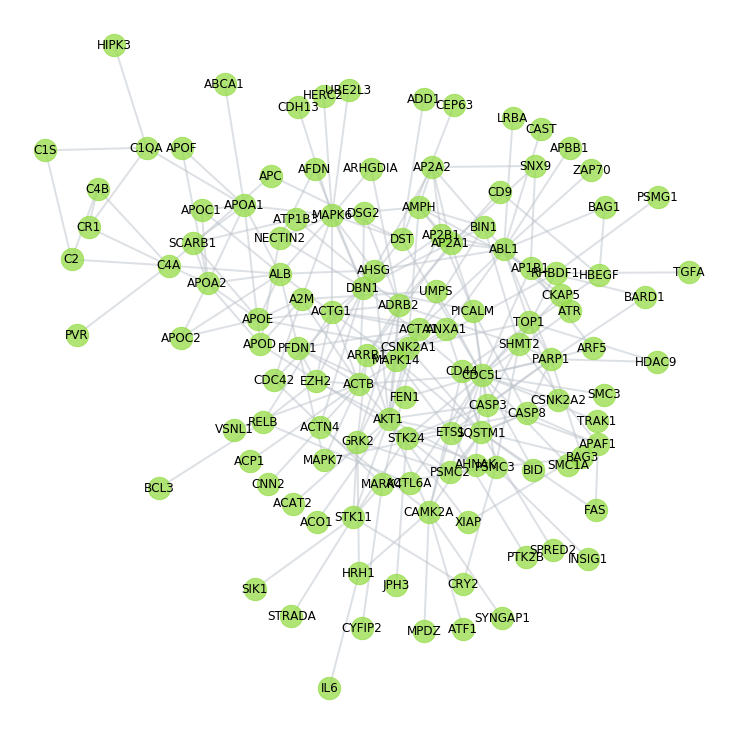

In [14]:
plt.figure(figsize=(10, 10))
nx.draw_kamada_kawai(
    net_LCC,
    node_color="#96dd49c0",
    node_size=500,
    width=2,
    edge_color="#bcc3cb80",
    labels={i:i for i in net_LCC.nodes()})
plt.show()
plt.close()

### Example - Network Proximity
In this section, we will use the disease gene list downloaded from Open Targets as an example to show the usages of the Network Proximity framework.

Several things to prepare first:
* load human protein interactome
* load drug-target network
* load gene id to symbol mapping

In [15]:
random.seed(1024)
Int = Interactome("data/human_interactome.adj")
Dtn = DrugTargetNetwork("data/drug_target_network.txt")
ID2Symbol = dict([line.split() for line in open("data/ID2Symbol.txt").read().splitlines()])

The disease associated gene list for PD can be downloaded from https://www.targetvalidation.org/disease/EFO_0002508/associations. Genes with a score of 1 are used for the downstream analyses.

In [16]:
PD_genes = open("data/PD.txt").read().splitlines()
PD_genes = [g for g in PD_genes if g in Int.nodes()]
print("Number of genes:", len(PD_genes))

Number of genes: 104


We look at whether these 104 genes form a significantly connected module in the protein interactome. The result show that 52 genes are connected in the largest connected component of theses genes, with a *P* value < 0.05.

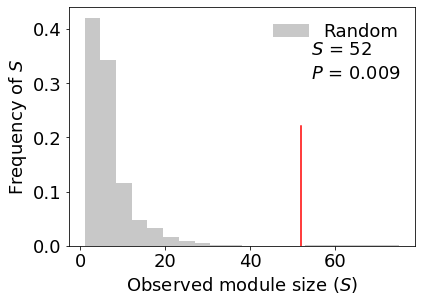

In [17]:
result = LCC_Z(Int, PD_genes)
Plot(result)

Let's visualize the LCC network. Blue indicates these nodes can be targeted by at least one drug from the drug target network.

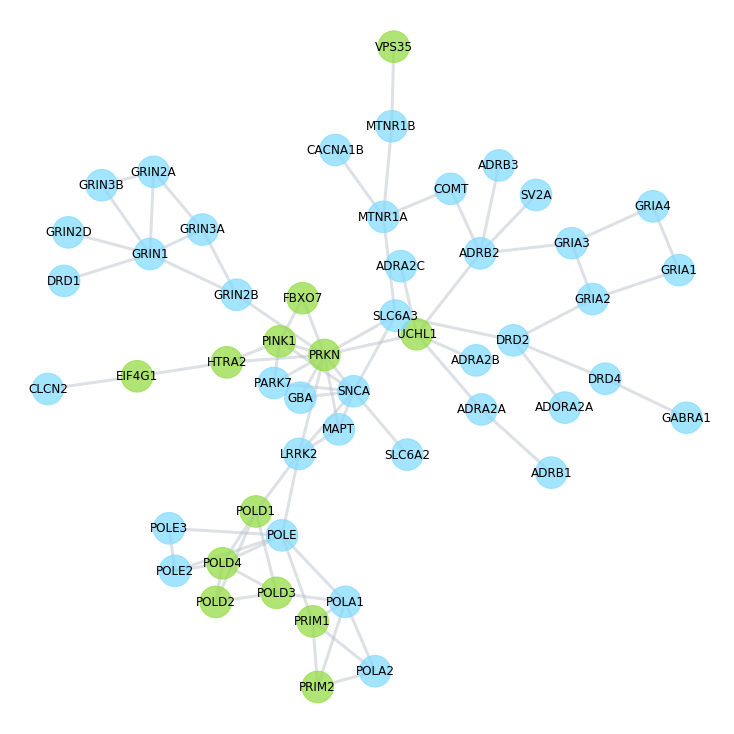

In [18]:
lcc = CC(Int, PD_genes)[0]
net = Int.subgraph(lcc)
labels = {n: ID2Symbol[n] for n in net.nodes()}
PlotNet(net, labels, Dtn)

Next we want to prioritize the drugs for the PD module to reveal potentially relavent drugs. There are more than 2,900 drugs in our drug target network, which takes some time to run completely. As an example, we will only test the first 20 drugs with permutation test of 100 repeats.

In [19]:
dtn = {d: Dtn[d] for d in sorted(Dtn)[:20]}
result = DrugScreen(Int, dtn, PD_genes, repeat=100)

drugbank2name = dict([line.strip("\n").split("\t") for line in open("data/drug_name.txt").read().splitlines()])

for r in result:
    print(drugbank2name[r["DRUG"]].ljust(30, " "), " D: %.1f  Z: %s%.3f  P: %.3f" % (r["D"], (" ", "")[int(r["Z"] < 0)], r["Z"], r["P"]))

Cetuximab                       D: 2.0  Z: -2.472  P: 0.000
Urokinase                       D: 2.1  Z: -1.264  P: 0.080
Erythropoietin                  D: 2.4  Z: -0.773  P: 0.340
Darbepoetin alfa                D: 2.4  Z: -0.635  P: 0.370
Sargramostim                    D: 2.2  Z: -0.631  P: 0.230
Denileukin diftitox             D: 2.3  Z: -0.465  P: 0.300
Interferon alfa-n3              D: 2.4  Z: -0.405  P: 0.500
Peginterferon alfa-2a           D: 2.4  Z: -0.375  P: 0.500
Interferon alfa-n1              D: 2.4  Z: -0.318  P: 0.560
Reteplase                       D: 2.3  Z: -0.172  P: 0.460
Alteplase                       D: 2.3  Z: -0.160  P: 0.460
Pegfilgrastim                   D: 2.4  Z: -0.150  P: 0.620
Secretin human                  D: 2.8  Z:  0.130  P: 0.510
Etanercept                      D: 2.1  Z:  0.134  P: 0.540
Salmon Calcitonin               D: 2.8  Z:  0.336  P: 0.620
Lepirudin                       D: 2.9  Z:  0.391  P: 0.630
Bivalirudin                     D: 2.9  

Cetuximab and Urokinase achieved small *P* values and *Z* scores. Literature search showed potential relations between these drugs and PD: https://ascopubs.org/doi/abs/10.1200/JCO.2019.37.15_suppl.3595, https://www.ncbi.nlm.nih.gov/pubmed/32035284

Let's take a closer look at the proximity between Urokinase and the PD module. This time we repeat the permutation test 1000 times. Note that the values may change slightly due to different random state. We then plot the proximity result.

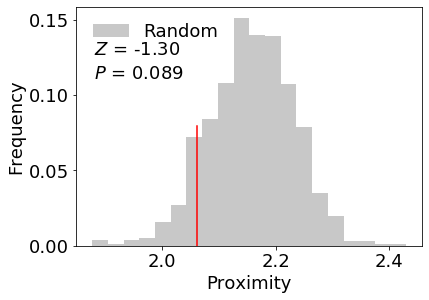

In [20]:
result = Proximity_Z(Int, PD_genes, dtn["DB00013"], repeat=1000)
Plot(result, labelX=0.05)